In [1]:


import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog

%matplotlib inline
image = mpimg.imread('test_images/test1.jpg')
car_images = glob.glob('training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

def extract_features_from_img(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):

    feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        
    return hog_features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

# Read in image similar to one shown above 


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
# heat = add_heat(heat,box_list)
    
# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,1)

# # Visualize the heatmap when displaying    
# heatmap = np.clip(heat, 0, 255)

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(image), labels)

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heatmap, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()



# import numpy as np
# feature_list = [feature_vec1, feature_vec2, ...]
# # Create an array stack, NOTE: StandardScaler() expects np.float64
# X = np.vstack(feature_list).astype(np.float64)

# from sklearn.preprocessing import StandardScaler
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)



# from skimage.feature import hog
# pix_per_cell = 8
# cell_per_block = 2
# orient = 9

# features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)



# img = cv2.imread('test_images/test1.jpg')

# # Select a small fraction of pixels to plot by subsampling it
# scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
# img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# # Convert subsampled image to desired color space(s)
# img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
# img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
# img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)


# img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# # Plot and show
# plot3d(img_small_RGB, img_small_rgb)
# plt.show()

# plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
# plt.show()

# plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
# plt.show()


# rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))


# # Here are the bounding boxes I used
# bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
#           ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]




# result = draw_boxes(image, bboxes)
# plt.imshow(result)


# image = mpimg.imread('test_images/cutout1.jpg')





# # Take histograms in R, G, and B
# rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
# ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
# bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))



# bin_edges = rhist[1]

# bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2



# # Plot a figure with all three bar charts
# fig = plt.figure(figsize=(12,3))
# plt.subplot(131)
# plt.bar(bin_centers, rhist[0])
# plt.xlim(0, 256)
# plt.title('R Histogram')
# plt.subplot(132)
# plt.bar(bin_centers, ghist[0])
# plt.xlim(0, 256)
# plt.title('G Histogram')
# plt.subplot(133)
# plt.bar(bin_centers, bhist[0])
# plt.xlim(0, 256)
# plt.title('B Histogram')



In [21]:
car_images = glob.glob('classifier/vehicles/**/*.png')
noncar_images = glob.glob('classifier/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8799 9992


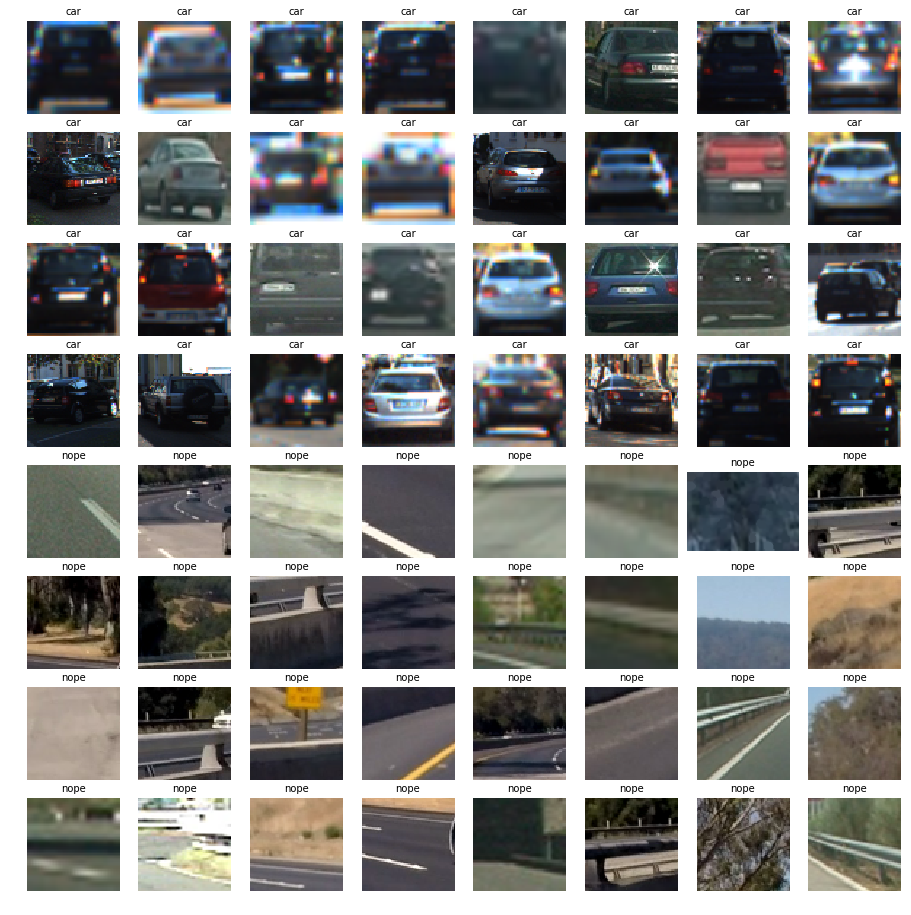

In [22]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

In [25]:
car_img = mpimg.imread(car_images[5])
_, car_dst = get_hog_features(car_img[:,:,0], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,0], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)
print('...')

...


In [57]:
# loading the data

from PIL import Image
import glob
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn import grid_search



from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split


%matplotlib inline

vehicles_images = []
nonvehicles_images = []

car_images = glob.glob('classifier/vehicles/**/*.png')
noncar_images = glob.glob('classifier/non-vehicles/**/*.png')

for filename in car_images: #assuming gif
    img=mpimg.imread(filename)
    img=cv2.resize(img,(64,64))
#    vehicles_images.append(img[:,:,0:3])#to avoid alpha channel enable 
    vehicles_images.append(img)
print(vehicles_images[0].shape)
print(vehicles_images[0].dtype)

for filename in noncar_images: #assuming gif
    img=mpimg.imread(filename)
    img=cv2.resize(img,(64,64))
   # nonvehicles_images.append(img[:,:,0:3])#to avoid alpha channel enable 
    nonvehicles_images.append(img)#to avoid alpha channel enable 
print(nonvehicles_images[0].shape)
print(nonvehicles_images[0].dtype)
print("Loading finished!")

(64, 64, 3)
float32
(64, 64, 3)
float32
Loading finished!


## Load the training data, and train the classifier

In [103]:


def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    img=cv2.resize(img,(64,64))
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)

    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)

    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)



def extract_features(imgs, cspace='YCrCb', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        s_imge_feature = single_img_features(image)
        features.append(s_imge_feature)
    print(len(features))
    print(features[0].shape)
    return np.array(features)



sample_size = 1000
random_idxs = np.random.randint(0,4500,sample_size)
cars = np.array(car_images)[random_idxs]
notcars = np.array(noncar_images)[random_idxs]

### TODO: Tweak these parameters and see how the results change.
# colorspace = 'YUV'#'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 11
# pix_per_cell = 16
# cell_per_block = 2
# hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()

print(cars.shape)
print(notcars.shape)



#X = np.concatenate((cars,notcars))
print("car size : ", len(cars),"not car size : ",len(notcars),"combine size is ",len(X))

car_features = extract_features(cars , cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
noncar_features = extract_features(notcars , cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
X = np.vstack((car_features,noncar_features))


print(X.shape)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors

X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

svc = LinearSVC()
svc.fit(X_train, y_train)


print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')






(1000,)
(1000,)
car size :  1000 not car size :  1000 combine size is  2000
1000
(8460,)
1000
(8460,)
(2000, 8460)
12.76 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
8.49 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  0.  1.  1.  0.  0.  1.  1.]
0.00195 Seconds to predict 10 labels with SVC


In [96]:
dist_pickle = {}
dist_pickle["svc"] =svc 
dist_pickle["scaler"] = X_scaler 
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size = (32,32)
dist_pickle["hist_bins"] = hist_bins = 32


pickle.dump(dist_pickle, open("svc_pickle.p", "wb"))



In [97]:
dist_pickle = pickle.load(open("svc_pickle.p", "rb" ))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]



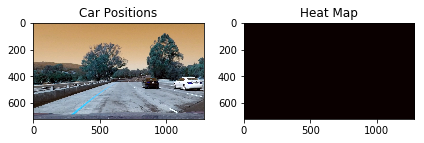

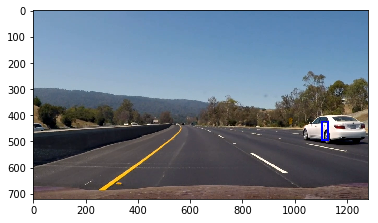

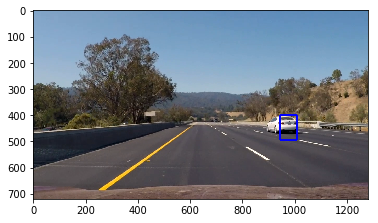

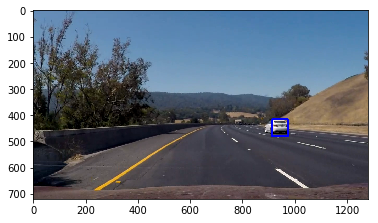

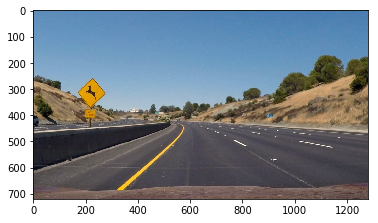

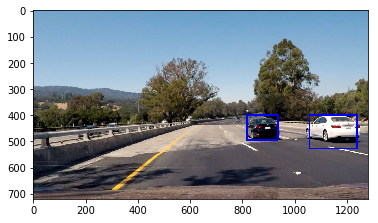

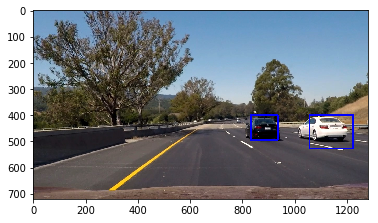

In [139]:


from scipy.ndimage.measurements import label

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    boxes = []
    
    draw_img = np.copy(img)
 #   img = img.astype(np.float32)/255
    img = img.astype(np.float32)/255
    heat_map = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    

    ctrans_tosearch = cv2.cvtColor(img_tosearch,  cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64#
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            #s_imge_feature = single_img_features(subimg)

            img_features = []
        
            # Get color features
            spatial_features = bin_spatial(subimg, size=(32,32))
            hist_features = color_hist(subimg, nbins=32)

            # Scale features and make a prediction
            
            #test = np.concatenate((spatial_features, hist_features,hog_features))
            img_features.append(spatial_features)
            img_features.append(hist_features)
            img_features.append(hog_features)
            img_features = np.concatenate(img_features)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))  
            #test_features = X_scaler.transform(np.reshape(hog_features,(1,-1)) )   
            #test =  test.reshape(1, -1)#np.array(test)
            #print(test.shape)
            #test_features = X_scaler.transform(img_features)
            #test_features = X_scaler.transform(s_imge_feature)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))                       
#                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
#    return draw_img,boxes
    return boxes



def draw_boxes_test(image):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))

    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(256, 256), xy_overlap=(0.5, 0.5))

    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
    plt.figure()
    plt.imshow(window_img)

    scale = 4
    #image = cv2.resize(image,((np.int(image.shape[1]/4), np.int(image.shape[0]/2))))
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(128*2, 128*1), xy_overlap=(0.5, 0.5))

    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    


    plt.figure()
    plt.imshow(window_img)

    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_image(image):
    ystart = 400
    ystop = 656

    scales = [1,1.5,2,2.5,3,3.5]
    box_list = []
    spatial_size=(32, 32)
    hist_bins=32
    orient=9
    pix_per_cell=8
    cell_per_block=2

    for scale in scales:
        boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
        box_list.extend(boxes)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    test_image = draw_boxes(np.copy(image),box_list)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

#draw_boxes_test(img)    
#img=mpimg.imread("test_images/test1.jpg")
img=cv2.imread("test_images/test.jpg")
img = mpimg.imread("test_images/7.png")

ystart = 400
ystop = 660
#plt.figure(figsize=(100, 100))
#scales = [1,1.5,2.0,2.5]

scales = [1,1.5,2,2.5,3,3.5]
box_list = []
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2

for scale in scales:
    boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
    box_list.extend(boxes)
    
heat = np.zeros_like(image[:,:,0]).astype(np.float)

test_image = draw_boxes(np.copy(image),box_list)

# Add heat to each box in box list
heat = add_heat(heat,box_list)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.figure(figsize=(100, 100))
plt.imshow(test_image)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()



test_images = glob.glob('test_images/*.jpg')

for filename in test_images: #assuming gif
    img=mpimg.imread(filename)
    draw_img = process_image(img)
    plt.figure()
    plt.imshow(draw_img)


In [132]:
def process_image2(image):
    ystart = 400
    ystop = 656

    scales = [1.5,2,2.5]
    box_list = []
    spatial_size=(32, 32)
    hist_bins=32
    orient=9
    pix_per_cell=8
    cell_per_block=2

    for scale in scales:
        boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
        box_list.extend(boxes)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    test_image = draw_boxes(np.copy(image),box_list)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [133]:
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

imageio.plugins.ffmpeg.download()


In [141]:
video_output = "project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")#.subclip(16,18)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output,audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [39:07<00:01,  1.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 37min 38s, sys: 2min 29s, total: 40min 8s
Wall time: 39min 8s


In [20]:
import os
def video_to_frames(video, path_output_dir):
    # extract frames from a video and save to directory as 'x.png' where 
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        
        
        vidcap.set(cv2.CAP_PROP_POS_MSEC,5000*count)      # just cue to 20 sec. position

        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, '%d.jp') % count, image)
            count += 1
        else:
            break
    cv2.destroyAllWindows()
    vidcap.release()

#video_to_frames('project_video.mp4', 'test_images/')


## Augment Data which capture from image

In [51]:
from imgaug import augmenters as iaa
import matplotlib.image as mpimg
import glob
import os
import imgaug as ia
import cv2
import matplotlib.pyplot as plt
%matplotlib inline



seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

seq_list = []
seq_list.append( iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
]) )
seq_list.append( iaa.Sequential([iaa.Crop(px=(0, 16))]) )
seq_list.append( iaa.Sequential([iaa.Fliplr(0.5)]) ) # horizontally flip 50% of all images
seq_list.append( iaa.Sequential([iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))])  )# convert images into their superpixel representation
seq_list.append( iaa.Sequential([iaa.Crop(percent=(0, 0.1))]))  # crop images by 0-10% of their height/width
seq_list.append( iaa.Sequential([iaa.GaussianBlur((0, 3.0))]) ) # blur images with a sigma between 0 and 3.0
#seq_list.append( iaa.Sequential([iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))]))  # sharpen images
#seq_list.append( iaa.Sequential([iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))]) ) # emboss images
seq_list.append( iaa.Sequential([iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.2), per_channel=0.5)]))  # add gaussian noise to images
seq_list.append( iaa.Sequential([iaa.Dropout((0.0, 0.1), per_channel=0.5)]))  # randomly remove up to 10% of the pixels
seq_list.append( iaa.Sequential([iaa.Invert(0.25, per_channel=True)]))  # invert color channels
seq_list.append( iaa.Sequential([iaa.Add((-10, 10), per_channel=0.5)]))  # change brightness of images (by -10 to 10 of original value)
seq_list.append( iaa.Sequential([iaa.Multiply((0.5, 1.5), per_channel=0.5)]))  # change brightness of images (50-150% of original value)
seq_list.append( iaa.Sequential([iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)]))  # improve or worsen the contrast
seq_list.append( iaa.Sequential([iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)])) 
seq_list.append( iaa.Sequential([iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
        translate_px={"x": (-16, 16), "y": (-16, 16)}, # translate by -16 to +16 pixels (per axis)
        rotate=(-45, 45), # rotate by -45 to +45 degrees
        shear=(-16, 16), # shear by -16 to +16 degrees
        order=ia.ALL, # use any of scikit-image's interpolation methods
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    )]) )
seq_list.append( iaa.Sequential([iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)]) )

def show_image(images, numberofimage_perline):

    num_lines = int(len(images)/numberofimage_perline)
    axarr =  []

    
    for index in range(num_lines):
        f, at = plt.subplots(1,numberofimage_perline,figsize=(20,20))
        axarr.append(at)
        

    for image,index in zip(images,range(0,len(images))):
        i1,i2 = divmod(index,5)
        axarr[i1][i2].imshow(image)

def augment_data(original_images):
    augment_images = []
    for seq,index in zip(seq_list,range(len(seq_list))):
        augment_images.extend(seq.augment_images(original_images))
    print("total augment image size is",len(augment_images))
    return augment_images
#    return  seq.augment_images(original_images)


def augment_folder(source_folder, target_folder):
    
    print(source_folder,target_folder)    


    test_images = []
    number_image_to_augment = 1000
    index =0
    for filename in glob.glob(source_folder +'/*.png'): 

        if index >= number_image_to_augment:
            break;
        index = index + 1    
        img=cv2.imread(filename)
        img = img[:,:,0:3]
        test_images.append(img)

    print(len(test_images)," images to process:")    
    augment_images = augment_data(test_images)

    #show_image(test_images,2)
    #show_image(augment_images,5)

    for img,index in zip(augment_images,range(len(augment_images))):
        img = cv2.resize(img, (64,64))
        mpimg.imsave(os.path.join(target_folder, '%d.png') % index, img)
                              
                              
augment_folder("classifier/vehicles/HandMade/","classifier/vehicles/augment_vehicles/")
#augment_folder("classifier/non-vehicles/HandMade/","classifier/non-vehicles/augment_vehicles/")

classifier/vehicles/HandMade/ classifier/vehicles/augment_vehicles/
17  images to process:
total augment image size is 255
